In [1]:
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib
import pandas as pd
import numpy as np
%matplotlib inline
import lightroot
from lightroot.detection import preprocessing
from lightroot.context import context
from lightroot.tracking import tpctree
c = context.folder_context("C:/Users/mrsir/Box Sync/CYCB-GFP/cut/April 4 (cut run 192)")

The directory ./cached_datax should be empty. Do you want to clear it? (y/n)n
17/09/2018 16:59:14|INFO||:>Setting a default value noise_trange:[0.01, 0.045]
17/09/2018 16:59:14|INFO||:>Setting a default value max_files:10000
17/09/2018 16:59:14|INFO||:>Setting a default value max_file_gap:100
17/09/2018 16:59:14|INFO||:>Setting a default value stack_file_format:C:/Users/mrsir/Box Sync/CYCB-GFP/cut/April 4 (cut run 192)\Run0192_tp{:0>3}.tif
17/09/2018 16:59:14|INFO||:>Data dir is set to C:/Users/mrsir/Box Sync/CYCB-GFP/cut/April 4 (cut run 192)
17/09/2018 16:59:14|INFO||:>Output dir is set to ./cached_datax
17/09/2018 16:59:14|INFO||:>Total_files:973
17/09/2018 16:59:14|INFO||:>Total_tiff_files:973
17/09/2018 16:59:14|INFO||:>Max_good_index:484
17/09/2018 16:59:14|INFO||:>First_good_index:0
17/09/2018 16:59:14|INFO||:>Frame_gaps:{}
17/09/2018 16:59:14|INFO||:>***********BEGIN PROCESSING LOOP***********
17/09/2018 16:59:14|INFO||:>loading settings file ./settings.json


# Plot the point distribution over time

Colour time and use frame detecitons for size - this helps to visually cluster same-objects while also singling out small single frame detections
An ellipse shows the region where we would be highly confident the detections correspond to real cells
A helper function should be use to filter the underlying points based on this - todo

In [13]:
import pandas as pd
import numpy as np
from numpy import nan
stats= pd.read_csv("./cached_datax/tree_stats.csv").drop("Unnamed: 0",1)
stats =stats.reset_index()

In [14]:
#todo - i changed out the data index is set by default, need to update
stats["data_t_index"] = stats["data_t_index"].fillna(stats["index"])

In [15]:


def expand_angles(data):
    all_data = []
    for k,r in data[["best_tr_angle", "marriage_angles", "data_t_index"]].set_index("data_t_index").dropna().iterrows():
        angles = pd.DataFrame(eval(r["marriage_angles"]))
        angles["t"] = k
        angles["tr"] = r["best_tr_angle"]
        angles["_diff_"] = np.abs(angles["angle"]-angles["tr"]) 
        for c in ["angle","tr"]: angles[c] = np.mod(np.mod((angles[c] + 360),360),180)
        angles["diff"] = np.abs(angles["angle"]-angles["tr"])                      
        all_data.append(angles)
    return pd.concat(all_data).round(2)

angles = expand_angles(stats)


In [16]:
df=pd.read_csv("./cached_datax/data.csv").drop("Unnamed: 0",1)
df = pd.merge(df,angles,on=["t","key"],how="left")
df["angle_diff"] = df["diff"] .fillna(0)
df["epsilon1"] = df["epsilon1"].fillna(0.1).round(1) * 10
df = df.set_index("key").join(df.groupby("key").count()["t"],rsuffix="detections")
df["is_single_frame"] = 0
df["size"] = 40
df.loc[df.tdetections<=1,"is_single_frame"] = 1
df.loc[df.tdetections<=1,"size"] = 10
df.head()

,angles,epsilon1,r,t,x,y,z,angle,tr,_diff_,diff,angle_diff,tdetections,is_single_frame,size
key,,,,,,,,,,,,,,,
0,NaN,1.0,25.980762,1,570.5,566.5,21.5,171.87,0.00,351.87,171.87,171.87,32,0,40
0,NaN,30.0,25.980762,2,592.5,564.5,22.5,16.70,35.54,18.84,18.84,18.84,32,0,40
0,NaN,46.0,25.980762,3,599.5,565.5,22.5,76.37,98.98,22.62,22.62,22.62,32,0,40
0,NaN,36.0,25.980762,4,609.5,562.5,22.5,135.00,135.00,0.00,0.00,0.00,32,0,40
0,NaN,18.0,25.980762,5,608.5,566.5,21.5,26.57,26.57,0.00,0.00,0.00,32,0,40


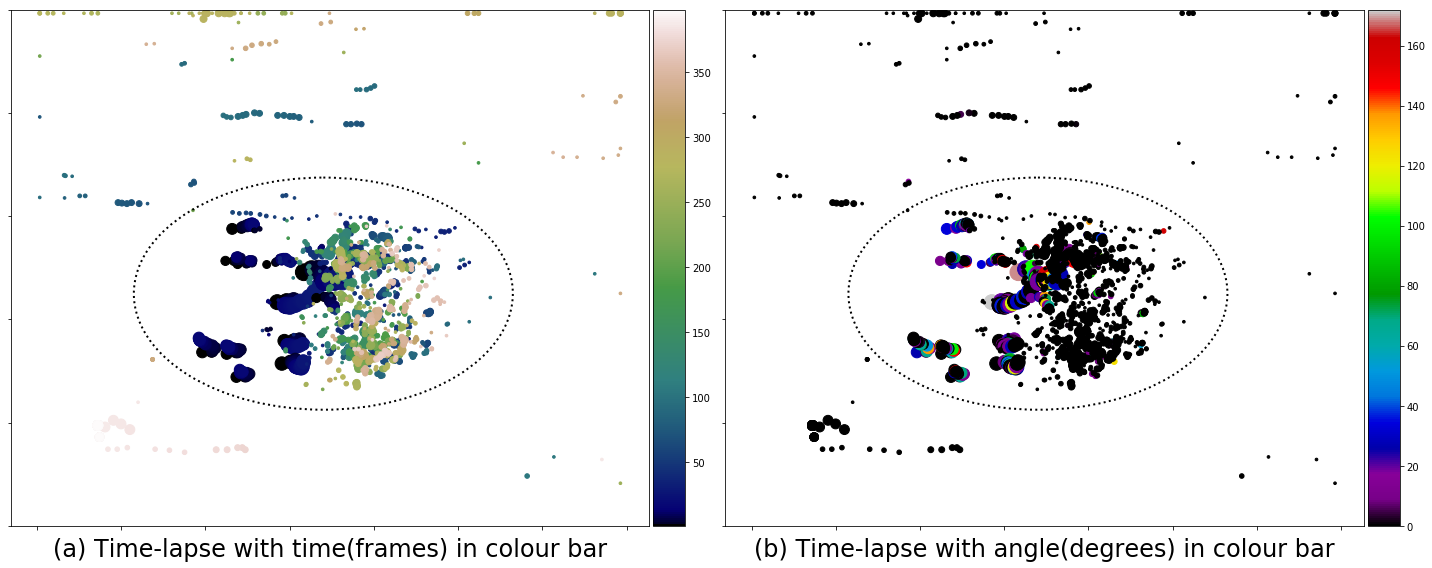

In [17]:
%matplotlib inline
import pandas as pd
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
#df=df[df.tdetections>1]
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 8), tight_layout=True)
colors = ["gist_earth", "spectral"] 
cols = ["t", "angle_diff"]
names = ["(a) Time-lapse with time(frames) in colour bar", "(b) Time-lapse with angle(degrees) in colour bar"]
for i, ax in enumerate([ax1,ax2]):
    s=ax.scatter(df.x, df.y, s=df["tdetections"]*7, c=df[cols[i]], cmap=colors[i])
    e= Ellipse((680, 550), 900, 450,linewidth=2, linestyle=":", fill=False,)
    ax.add_artist(e)
    ax.set_ylim(1000,0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel(names[i],fontsize=24)
    cb = plt.colorbar(s,make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05))
fig.savefig("./samples/Fig11.pdf",bbox_inches='tight')

In [ ]:
angles = pd.DataFrame(entry["marriage_angles"]).set_index("key").dropna()#[0:5]
plots.plot_disp_angles(entry["best_tr_angle"], angles.values, angles.index)

# Sample Frames

In [ ]:
ims = [c.load_frame(i) for i in [0,45,81,99]]
F = lightroot.plots.plot_quad(ims)     
F.axes[0].annotate('root tip', color='white',xy=(120, 120), xytext=(140, 140),xycoords='axes pixels', fontsize=16,
            arrowprops=dict(facecolor='white', shrink=0.05))    
F.axes[0].annotate('debris', color='white',xy=(240, 145), xytext=(200, 100),xycoords='axes pixels', fontsize=16,
            arrowprops=dict(facecolor='white', shrink=0.05))    
F.savefig("./samples/sample_frames.pdf",bbox_inches='tight')

# ROI Stages

In [ ]:
import matplotlib.patches as patches
def show_stages(c, i):    
    f0=c.load_frame(i)
    f1=preprocessing.denoise(f0,c)
    preprocessing.select_filtered_by_2d_lowband_largest_component(f1,c)#record the bounding box
    f2 = preprocessing.lowband_histogram_thresholding(f1.sum(0),c)
    f3 = preprocessing.smoothing(f2,c,props={"sigma":12})

    def cb (I,ax):
        inlay=0
        rect = c.bbox
        ax.imshow(I)
        ax.add_patch( patches.Rectangle(  list(reversed(rect[0:2])),   rect[3]-rect[1]-inlay,   rect[2]-rect[0]-inlay,  fill=False, edgecolor='white' ))

    return lightroot.plots.plot_quad([f1,f2,f3,f1], pals=["gist_earth", "Blues", "Blues", "gist_earth"], callbacks={3:cb}) 

res = show_stages(c,45)
F.savefig("./samples/roi_stages.pdf",bbox_inches='tight')

## load sample data...

In [2]:
frame_stats = pd.read_csv("./samples/test_stats390.csv")
frame_stats.head()
test_data = pd.read_csv("./samples/test_points.csv").drop("Unnamed: 0",1)

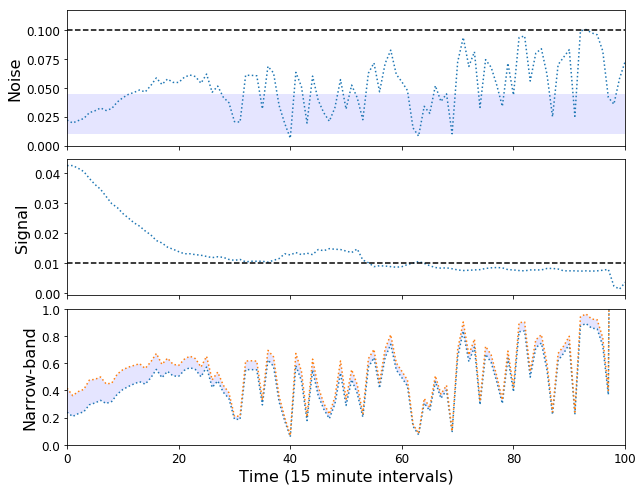

In [3]:
lightroot.plots.frame_stats(frame_stats,file="./samples/Fig01b.pdf")

# Constellation sampling

In [ ]:
d1 = test_data[test_data.t==9].reset_index().drop("index",1)
d2 = test_data[test_data.t==10].reset_index().drop("index",1)
t = tpctree(d1)
t.update(test_data[test_data.t==10])
p = {"c":"b", "canvasx": [400,800,800,400],"canvasy": [700,700,350,350] }
cn = list(tpctree.constellation_sampler(d1,N=6))
_call=lightroot.utils.render_constellation_callback(cn)
cn = list(tpctree.constellation_sampler(d2,N=50))
_call=lightroot.utils.render_constellation_callback(cn)
ax= c._iom.plot(None, blob_overlay=d2, props=p,callback=_call)
ax.set_xlabel("x axis (pixels)", fontsize=20)
ax.set_ylabel("y axis (pixels)", fontsize=20)

plt.savefig("./samples/Fig04.pdf",bbox_inches='tight')

# Transform eval

In [ ]:
c._iom.plot(None, blob_overlay=d1,  props=p,callback=tpctree.show_projection_callback(d2, tr=t._last_transform))
plt.xlabel("x axis (pixels)", fontsize=20)
plt.ylabel("y axis (pixels)", fontsize=20)
plt.savefig("./samples/Fig05.pdf",bbox_inches='tight')

# Life Matrix

In [4]:
lm = tpctree.make_life_matrix(pd.read_csv("./samples/test_tree_blobs.csv")).astype(int)
restricted = tpctree.make_life_matrix(pd.read_csv("./samples/test_tree_blobs.csv"),True).astype(int)
#_lm = lm# if we want to show all in time series plots
_lm = restricted
bandd = _lm.diff(1,axis=1,).fillna(0) #* lifetime_matrix
births = bandd[bandd==1].fillna(0)
deaths = np.abs(bandd[bandd==-1]).fillna(0)
ageMat = _lm.cumsum(axis=1) * _lm
lm.head()

,0,1,2,3,4,5,6,7,8,9,...,381,382,383,384,385,386,387,388,389,390
0.0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1.0,1,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2.0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3.0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4.0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


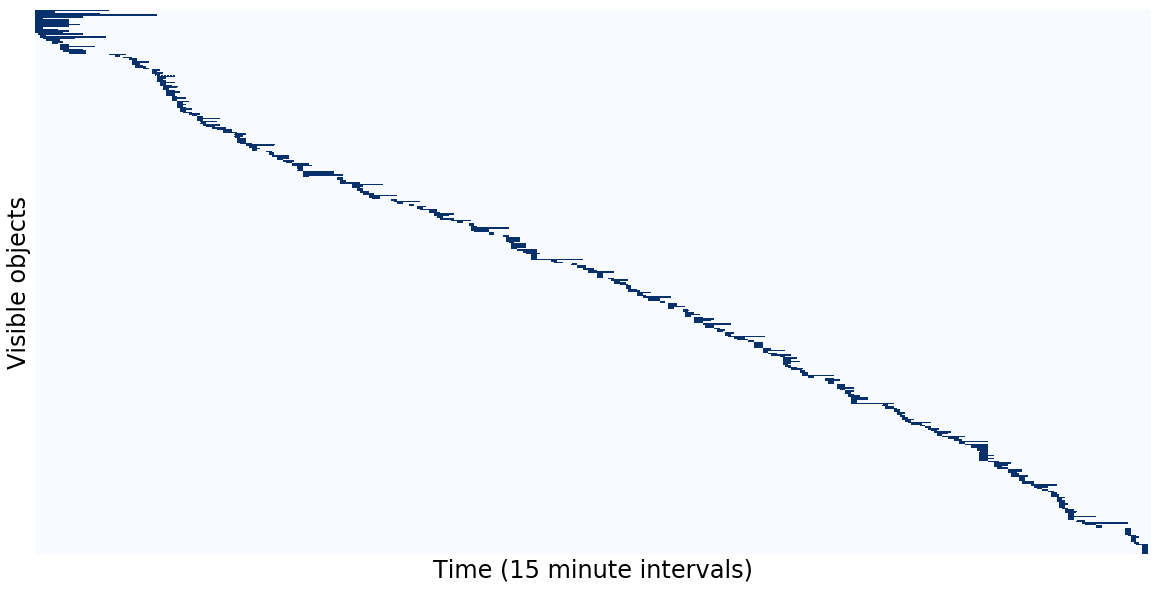

In [12]:
import seaborn as sns
fig = plt.figure(figsize=(20,10))
sns.heatmap(restricted.astype(int),cmap="Blues",cbar=False,yticklabels=False, xticklabels=False)
plt.ylabel("Visible objects",fontsize=24)
plt.xlabel("Time (15 minute intervals)",fontsize=24)
pdf = PdfPages("./samples/Fig06.pdf")
pdf.savefig(fig)
pdf.close()
plt.savefig("./samples/Fig06_png.png",bbox_inches='tight') #save as pdf takes some time - can save as png instead

# Time Series

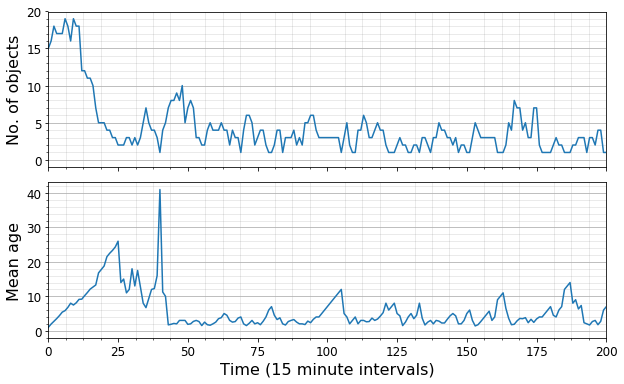

In [8]:
time = restricted.sum(axis=0).reset_index().drop("index",1)
time.columns = ["alive"]
time["births"] = births.sum()
time["deaths"] = deaths.sum()
time["observed_by_t"] = births.sum().cumsum().astype(int)
time["mean_age_at_t"]  = ageMat.replace(0, np.nan).mean(skipna=True).round(2).fillna(0)
time.index.name = 't'
time = time.reset_index()

temp = time

matplotlib.rcParams.update({'font.size': 12})
fig, (ax1, ax2) = plt.subplots(2,  figsize=(10,6), sharex=True)

axis_fig_size=16
ax1.plot(temp.index, temp.alive, '-')

ax1.set( ylabel='No. of objects')
ax1.yaxis.label.set_size(axis_fig_size)
ax1.yaxis.grid()
ax1.minorticks_on()
ax1.grid(b=True, which='minor', color='grey', linestyle='-', alpha=0.2)

ax2.plot(temp.index, temp.mean_age_at_t, '-')
ax2.set(ylabel='Mean age',)
ax2.yaxis.label.set_size(axis_fig_size)
ax2.xaxis.label.set_size(axis_fig_size)
ax2.yaxis.grid()

plt.subplots_adjust(hspace=0.1)
plt.xlim(0,200)
plt.xlabel("Time (15 minute intervals)",fontsize=axis_fig_size)
ax2.minorticks_on()
ax2.grid(b=True, which='minor', color='grey', linestyle='-', alpha=0.2)
fig.savefig("./samples/Fig07.pdf",bbox_inches='tight')

In [ ]:
plt.figure(figsize=(10,5))
ah = pd.DataFrame(ageMat.max(axis=1),columns=["age_hist"])
ah['age_hist'].plot.hist(bins=40,ylim=(0,250)) 

In [ ]:
# ghj = frame_stats[["bbox_area"]][0:100]
# ghj["bounding box area"] = ghj["bbox_area"]/ghj["bbox_area"].max()
# ghj["1-frame detections"] = (lm.sum()-restricted.sum())/lm.sum()
# ax  =ghj[["bounding box area","1-frame detections"]].fillna(0).plot(figsize=(20,3),kind='area', stacked=False, alpha=0.3)
# #ax.figure.savefig("f8.pdf",bbox_inches='tight')

# Epsilon values

In [10]:
# lms = []
eps = [10,15,20,25,30,35,40,50,70]
# for epsilon in eps:
#     print("epsilon", epsilon)
#     data = pd.read_csv("./samples/test_tree_blobs.csv")
#     data = data[["t","x","y", "z"]]
#     tree=None
#     for g,d in data.groupby("t"):
#         print(".", end="")
#         if g %10 ==0:print()
#         if tree == None: tree = tpctree(d,options={"epsilon":epsilon})
#         else: tree.update(d) 
#         if g == 100:break
#     lms.append(tpctree.make_life_matrix(tree.data).astype(int))
# ghj = frame_stats[["bbox_area"]][0:100]
# ghj["bounding box area"] = ghj["bbox_area"]/ghj["bbox_area"].max()
# for i,_lm in enumerate(lms):
#     ghj["1-frame detections @ "+str(eps[i])] = (_lm.sum()-tpctree.get_restricted(_lm).sum())/_lm.sum()
# ghj.to_csv("./samples/epsilon_sfd_checks.csv")

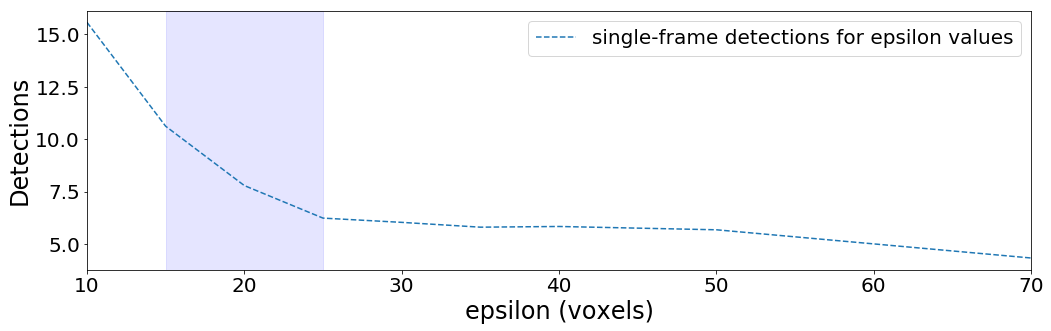

In [11]:
ghj = pd.read_csv("./samples/epsilon_sfd_checks.csv").drop("Unnamed: 0",1)
matplotlib.rc('text', usetex=False, fontsize=20)
totals = ghj.sum().reset_index()[2:].set_index(np.array(eps))
totals.columns = ["label", "single-frame detections for epsilon values"]
totals.index.name = "epsilon"
ax = totals[["single-frame detections for epsilon values"]].plot(style='--',figsize=(15,5))
ax.axvspan(15,25, alpha=0.1, color='blue')
ax.set_ylabel("Detections",fontsize=24)
ax.set_xlabel("epsilon (voxels)",fontsize=24)
plt.tight_layout()
pdf = PdfPages("./samples/Fig08.pdf")
pdf.savefig(ax.figure)
pdf.close()
    
ax.figure.savefig("./samples/Fig08.png",bbox_inches='tight')

In [ ]:
# %matplotlib inline
# from matplotlib import pyplot as plt
# comparison = tree.data.dropna()#[tree.data.key != tree.data.key3].dropna()
# lm = tpctree.make_life_matrix(tree.data).astype(int)
# ageMat = lm.cumsum(axis=1) * lm
# def age_at(t,i):return ageMat[t][i]
# def age_at_px(row): return age_at(row["t"],row["key"])
# comparison["age"]=comparison.reset_index().apply(age_at_px, axis=1)
# comparison.key2 = comparison.key2.astype(int)
# comparison.key3 = comparison.key3.astype(int)

# #forced agreement - because we just want valid devaitions
# comparison.loc[comparison.age < 2, "key2"] = comparison.key
# comparison.loc[comparison.age < 3, "key3"] = comparison.key
# comparison["agree_a"] = (comparison.key == comparison.key2).astype(int)
# comparison["agree_b"] = (comparison.key == comparison.key3).astype(int)
# comparison["agree_c"] = (comparison.key2 == comparison.key3).astype(int)
# comp = comparison.groupby("t").sum()[["agree_a", "agree_b"]].join(comparison.groupby("t").count()["agree_c"])

# comp.columns=["Agreement 1:2", "Agreement 1:3", "Total"]
# comp["First Differance"] = comp["Total"] - comp["Agreement 1:2"]
# comp["Second Differance"] = comp["Total"] - comp["Agreement 1:3"]

# comp = comp[0:20]
# comp[["Agreement 1:2", "Agreement 1:3", "Total"]].plot(kind="area",stacked=False,alpha=1.,figsize=(15,7), colormap='Greys')
# comp[["First Differance","Second Differance"]].plot(figsize=(15,7))

# sfds = pd.DataFrame((lm.sum()-restricted.sum()))
# sfds.columns=["sfds"]

# plt.savefig("f10.pdf",bbox_inches='tight')